<a href="https://colab.research.google.com/github/getitmoon/supersentiment/blob/main/goemotions_w_glove_300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparing Data**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import list_datasets, load_dataset
from pprint import pprint

In [ ]:
dataset = load_dataset('go_emotions', split=['train', 'validation', 'test'])

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
raw_train_dataset = dataset[0].map(remove_columns=['id'])

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

In [ ]:
raw_validation_dataset = dataset[1].map(remove_columns=['id'])

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [ ]:
raw_test_dataset = dataset[2].map(remove_columns=['id'])

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
# !pip install transformers

In [ ]:
# from transformers import BertTokenizerFast, logging as transformers_logging

# transformers_logging.set_verbosity_warning()

# tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [ ]:
import spacy

spacy_en = spacy.load('en_core_web_sm')

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
def make_one_hot(labels):
  one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  for idx in labels:
    one_hot[idx] = 1
  return one_hot

In [ ]:
class dataset:
  def __init__(self, src, trg):
    self.src = src
    self.trg = trg

In [ ]:
print(tokenize_en(raw_train_dataset['text'][0]))

['My', 'favourite', 'food', 'is', 'anything', 'I', 'did', "n't", 'have', 'to', 'cook', 'myself', '.']


In [ ]:
from torchtext.vocab import GloVe
global_vectors = GloVe(name='6B', dim=300)

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
.vector_cache/glove.6B.zip: 862MB [02:55, 4.91MB/s]                           
100%|█████████▉| 399999/400000 [00:53<00:00, 7475.61it/s]


In [ ]:
def preprocessing(src_dst, trg_dst, raw_dataset): # should be only used by latter codes
  global VOCAB_stoi, VOCAB_itos, frequency, index
  for d in raw_dataset:
    # remove '[NAME]' in the sentence
    tokenized = tokenize_en(d['text'].replace('[NAME]', '').strip().lower())
    if (len(tokenized) > 32):
      tokenized = tokenized[:32]
    embedded = []
    diff = 32 - len(tokenized)
    for i in range(diff):
      tokenized.append('PAD') # consider making attention mask(addition!!!)
    for i in range(len(tokenized)):
      embedded.append(global_vectors.get_vecs_by_tokens([tokenized[i]], lower_case_backup=True).squeeze())
    src_dst.append(torch.stack(embedded))
    trg_dst.append(make_one_hot(d['labels']))

In [ ]:
# train dataset
tokenized_train_src = []
train_trg = []
preprocessing(tokenized_train_src, train_trg, raw_train_dataset)

# validation dataset
tokenized_validation_src = []
validation_trg = []
preprocessing(tokenized_validation_src, validation_trg, raw_validation_dataset)

# test dataset
tokenized_test_src = []
test_trg = []
preprocessing(tokenized_test_src, test_trg, raw_test_dataset)

In [ ]:
tokenized_train_src[0]

tensor([[-0.2275, -0.1366, -0.3900,  ..., -0.1844, -0.3823,  0.5535],
        [ 0.3401,  0.5711,  0.4501,  ...,  0.3548, -0.8317,  0.1224],
        [ 0.3854,  0.3425,  0.2960,  ..., -0.4994, -0.2751, -0.6136],
        ...,
        [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726],
        [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726],
        [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726]])

In [ ]:
print(len(raw_train_dataset), len(raw_validation_dataset), len(raw_test_dataset))

43410 5426 5427


In [ ]:
print(len(tokenized_train_src), len(train_trg), len(tokenized_validation_src), len(validation_trg), len(tokenized_test_src), len(test_trg))

43410 43410 5426 5426 5427 5427


## encoding

## batched dataset

In [ ]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

def batch(src, trg):
  batched = []
  one_batch_s = []
  one_batch_t = []
  i = 0
  for s,t in zip(src, trg):
    i += 1
    one_batch_s.append(s)
    one_batch_t.append(t)
    if (i == BATCH_SIZE): # append batch and initialize
      batched.append(dataset(torch.stack(one_batch_s).to(device), torch.tensor(one_batch_t).to(device)))
      one_batch_s = []
      one_batch_t = []
      i = 0
  if i != BATCH_SIZE:
    batched.append(dataset(torch.stack(one_batch_s).to(device), torch.tensor(one_batch_t).to(device)))
  return batched

In [ ]:
# batched train dataset
train_dataset = batch(tokenized_train_src, train_trg)

# batched validation dataset
validation_dataset = batch(tokenized_validation_src, validation_trg)

# batched test dataset
test_dataset = batch(tokenized_test_src, test_trg)

In [ ]:
print(train_dataset[0].src)
print(train_dataset[0].src.size())

tensor([[[-0.2275, -0.1366, -0.3900,  ..., -0.1844, -0.3823,  0.5535],
         [ 0.3401,  0.5711,  0.4501,  ...,  0.3548, -0.8317,  0.1224],
         [ 0.3854,  0.3425,  0.2960,  ..., -0.4994, -0.2751, -0.6136],
         ...,
         [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726],
         [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726],
         [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726]],

        [[-0.3918,  0.0430,  0.2727,  ..., -0.4052,  0.0125,  0.0935],
         [-0.2336,  0.3593, -0.0687,  ..., -0.7133, -0.0104,  0.3322],
         [-0.5206,  0.4956,  0.0329,  ..., -0.3506, -0.2220,  0.1428],
         ...,
         [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726],
         [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726],
         [-0.0305, -0.2272,  0.3878,  ..., -0.4162, -0.6488,  0.0726]],

        [[-0.0721, -0.1442,  0.0184,  ..., -0.1755,  0.1228,  0.4153],
         [ 0.0466,  0.2132, -0.0074,  ...,  0

## **Building the Model**

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        ''' Input Embedding '''
        # self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src):

        ## TODO: write down the forward step
        seq_length = src.size(1)
        # positional embedding dimension: S x H
        embedded_pos = self.pos_embedding(torch.arange(seq_length, device=self.device))
        # token embedding, dimension: B x S x H
        embedded_tok = src
        # self.tok_embedding(src)
        # two embeddings added, dimension: B x S x H; positional embedding broadcasted
        embedded = torch.add(embedded_tok, embedded_pos)

        output = embedded
        for layer in self.layers:
          output = layer(output, None)
          output = self.dropout(output)

        hidden = output[:,:,-1]

        return output, hidden

### Encoder layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self-Attention '''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # TODO: write your code
        # multihead attention
        # dimension: B x S x H
        x_a, _ = self.self_attention(src, src, src, src_mask)
        x_a = self.self_attn_layer_norm(self.dropout(x_a) + src)
        # positionwise feed forward
        x_f = self.positionwise_feedforward(x_a)
        src = self.ff_layer_norm(self.dropout(x_f) + x_a)

        return src

### Multi Head Attention Layer

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # TODO: write your code
        # assumption: hid_dim is a multiple of n_heads
        self.n_heads = n_heads

        self.weight_query = nn.Linear(hid_dim, hid_dim)
        self.weight_key = nn.Linear(hid_dim, hid_dim)
        self.weight_value = nn.Linear(hid_dim, hid_dim)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask = None):

        # TODO: write your code
        # dimension: B x S(1/2/3) x n_heads x H/n_heads
        Q = self.weight_query(query).view(query.size(0), query.size(1), self.n_heads, -1)
        K = self.weight_key(key).view(key.size(0), key.size(1), self.n_heads, -1)
        V = self.weight_value(value).view(value.size(0), value.size(1), self.n_heads, -1)

        # dimension: B x n_heads x S x H/n_heads
        Q, K, V = torch.transpose(Q, 1, 2), torch.transpose(K, 1, 2), torch.transpose(V, 1, 2)
        # dimension: B x n_heads x S1(query sentence length) x S2(key sentence length)
        dot = torch.matmul(Q, torch.transpose(K, 2, 3))
        scaled_dot = torch.div(dot, self.scale)
        if mask is not None:
          scaled_dot = scaled_dot.masked_fill(mask, -1e19) # -math.inf

        # attention dimension: B x n_heads x S1 x S2
        attention = nn.functional.softmax(scaled_dot, dim=3)

        attention = self.dropout(attention)
        # dimension: B x n_heads x S1 x H/n_heads
        weighted_sum = torch.matmul(attention, V) # V dimension: B x n_heads x S x H/n_heads
        # concat multiheads
        x = torch.cat([weighted_sum[:, i, :, :] for i in range(self.n_heads)], dim=-1)

        return x, attention

### Position-wise Feedforward Layer

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # TODO: write your code
        self.linear1 = nn.Linear(hid_dim, pf_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # TODO: write your code
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x

### Sequence-to-sequence model

In [ ]:
class Classification(nn.Module):
    def __init__(self,
                 encoder,
                 hid_dim,
                 out_dim,
                 device):
        super().__init__()

        self.encoder = encoder
        self.linear = nn.Linear(hid_dim, out_dim) # can add more!!!
        self.device = device


    def forward(self, src, trg=None):

        ## TODO: write down the forward step
        # encoder output dimension: B x S_en x H
        en_output, _ = self.encoder(src)
        en_output = torch.sum(en_output, 1) # B x H
        # B x O
        output = self.linear(en_output)

        return output

### Training the Seq2Seq Model

In [ ]:
OUTPUT_DIM = 28
HID_DIM = 300
ENC_LAYERS = 3 #2
ENC_HEADS = 4
ENC_PF_DIM = 300
ENC_DROPOUT = 0.1


enc = Encoder(HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

In [ ]:
model = Classification(enc, HID_DIM, OUTPUT_DIM, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,396,528 trainable parameters


We initialize model weights

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

### Training

In [ ]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here
        output = model(src)
        # loss
        loss = criterion(output, trg.float())

        # perform a backwared pass, and update the weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here
            output = model(src)
            # loss
            loss = criterion(output, trg.float())

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataset, optimizer, criterion)
    valid_loss = evaluate(model, validation_dataset, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 8s
	Train Loss: 0.437
	 Val. Loss: 0.185
Epoch: 02 | Time: 0m 6s
	Train Loss: 0.228
	 Val. Loss: 0.167
Epoch: 03 | Time: 0m 6s
	Train Loss: 0.198
	 Val. Loss: 0.151
Epoch: 04 | Time: 0m 6s
	Train Loss: 0.181
	 Val. Loss: 0.132
Epoch: 05 | Time: 0m 6s
	Train Loss: 0.168
	 Val. Loss: 0.120
Epoch: 06 | Time: 0m 6s
	Train Loss: 0.151
	 Val. Loss: 0.115
Epoch: 07 | Time: 0m 6s
	Train Loss: 0.138
	 Val. Loss: 0.111
Epoch: 08 | Time: 0m 6s
	Train Loss: 0.127
	 Val. Loss: 0.109
Epoch: 09 | Time: 0m 6s
	Train Loss: 0.117
	 Val. Loss: 0.106
Epoch: 10 | Time: 0m 6s
	Train Loss: 0.108
	 Val. Loss: 0.103
Epoch: 11 | Time: 0m 7s
	Train Loss: 0.102
	 Val. Loss: 0.104
Epoch: 12 | Time: 0m 7s
	Train Loss: 0.097
	 Val. Loss: 0.104
Epoch: 13 | Time: 0m 7s
	Train Loss: 0.093
	 Val. Loss: 0.104
Epoch: 14 | Time: 0m 7s
	Train Loss: 0.090
	 Val. Loss: 0.107
Epoch: 15 | Time: 0m 7s
	Train Loss: 0.087
	 Val. Loss: 0.111


In [ ]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_dataset, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 0.103


In [ ]:
w = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
TP = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
TN = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
FP = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
FN = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
def assign_f1 (pred_, label_):
  for pred, label in zip(pred_, label_): # for each batch
    for i in range(len(pred)):
      if label[i] == 1: # count true instances
        w[i] += 1
      if pred[i] == 1 and pred[i] == label[i]: # TP
        TP[i] += 1
      elif pred[i] == 1 and pred[i] != label[i]: # FP
        FP[i] += 1
      elif pred[i] == 0 and pred[i] == label[i]: # TN
        TN[i] += 1
      else: # FN
        FN[i] += 1

def get_f1_score (is_weighted):
  precision = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  recall = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  F1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  for i in range(len(TP)):
    if (TP[i] != 0):
      precision[i] = TP[i] / (TP[i] + FP[i])
      recall[i] = TP[i] / (TP[i] + FN[i])
      F1[i] = 2*precision[i]*recall[i] / (precision[i] + recall[i])
  tot_precision = 0
  tot_recall = 0
  tot_f1_score = 0
  if (is_weighted):
    s = sum(w)
    for i in range(len(w)):
      weight = w[i]/s
      tot_precision += weight * precision[i]
      tot_recall += weight * recall[i]
      tot_f1_score += weight * F1[i]
  else:
    l = len(precision)
    tot_precision = sum(precision) / l
    tot_recall = sum(recall) / l
    tot_f1_score = sum(F1) / l
  return tot_precision, tot_recall, tot_f1_score

In [ ]:
def evaluate_f1(iterator, model, threshold=0.5, is_weighted=True):
    model.eval()

    with torch.no_grad():
        check = 0
        for batch in iterator:
            src = batch.src
            trg = batch.trg

            output = model(src)
            output = torch.sigmoid(output)
            predicted = (output > threshold).int()

            labels = trg.int()

            assign_f1(predicted.tolist(), labels.tolist())

    precision, recall, f1 = get_f1_score(is_weighted) # weighted

    return precision, recall, f1

boolean = True
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.5, boolean)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5926
Recall: 0.5331
F1 Score: 0.5202


In [ ]:
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.5, False)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5419
Recall: 0.3941
F1 Score: 0.4151


In [ ]:
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.2, boolean)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5232
Recall: 0.5852
F1 Score: 0.5212


In [ ]:
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.1, boolean)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.4637
Recall: 0.6298
F1 Score: 0.5110


In [ ]:
def classify_sentence(sentence, model, device, max_len = 50):

    model.eval()

    tokenized = tokenize_en(sentence.lower())
    if (len(tokenized) > 32):
      tokenized = tokenized[:32]
    embedded = []
    diff = 32 - len(tokenized)
    for i in range(diff):
      tokenized.append('PAD') # consider making attention mask(addition!!!)
    for i in range(len(tokenized)):
      embedded.append(global_vectors.get_vecs_by_tokens([tokenized[i]], lower_case_backup=True).squeeze())
    src = torch.tensor(torch.stack(embedded))
    sentiment = model(src.view(1,32,300).to(device))

    return sentiment

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
sentiment = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [ ]:
def display_sentiment(sentence):
    global sentiment, model, device
    res = classify_sentence(sentence, model, device)
    res = nn.functional.softmax(res, -1).squeeze().tolist()
    res = [int(1000*d)/1000 for d in res]

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(sentiment, res)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    plt.show()
    plt.close()

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


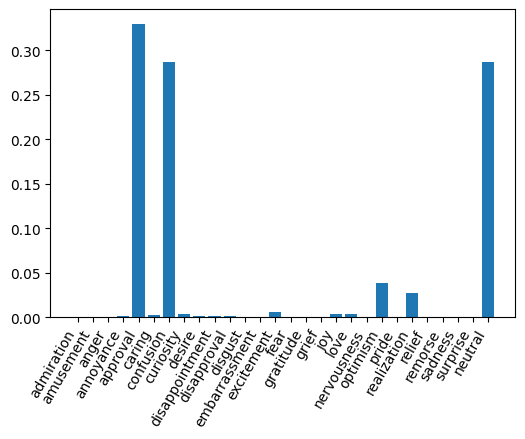

In [ ]:
display_sentiment("i am sure that i can do it")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


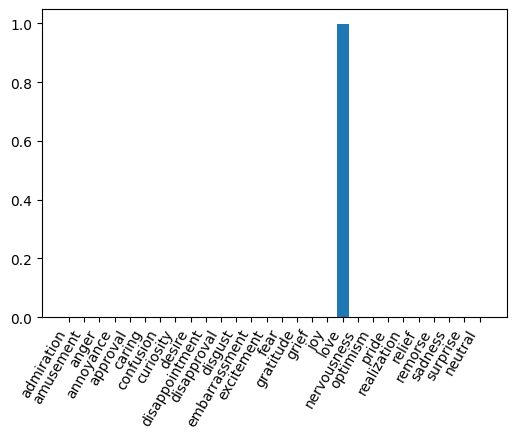

In [ ]:
display_sentiment("i love myself")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


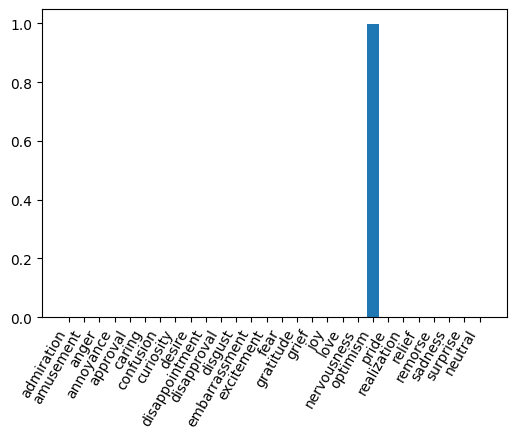

In [ ]:
display_sentiment("i hope i can do well")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


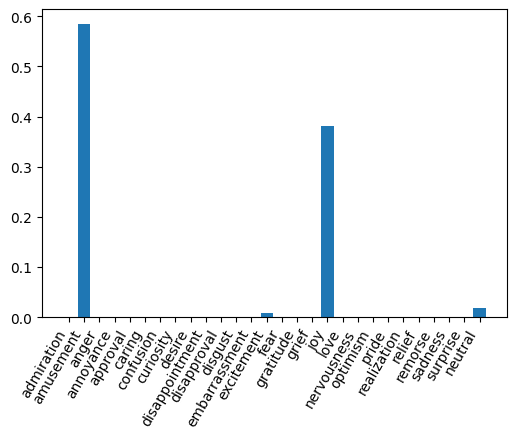

In [ ]:
display_sentiment("this is fun")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


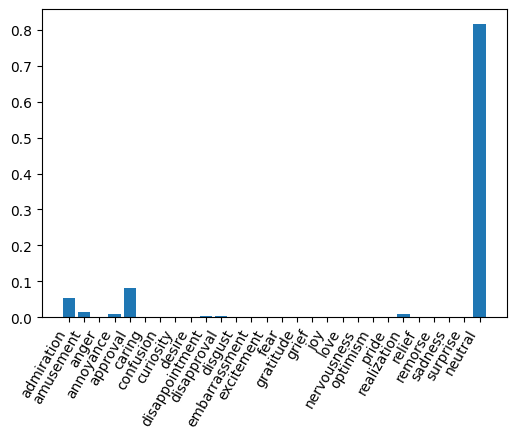

In [ ]:
display_sentiment("This is too accurate 😂")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


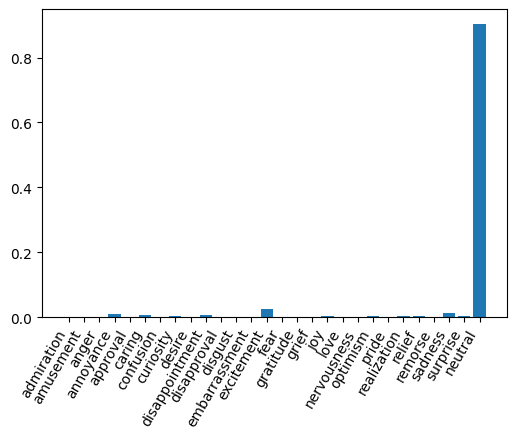

In [ ]:
display_sentiment("cant wait to go through a rebranded version of this pain again in college too")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


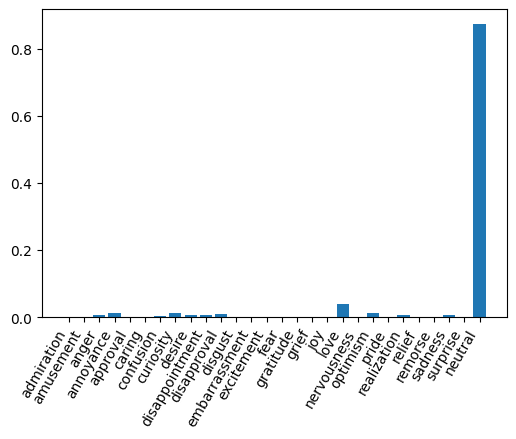

In [ ]:
display_sentiment("hold fast to dreams for if dreams die life is a broken-winged bird that cannot fly.")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


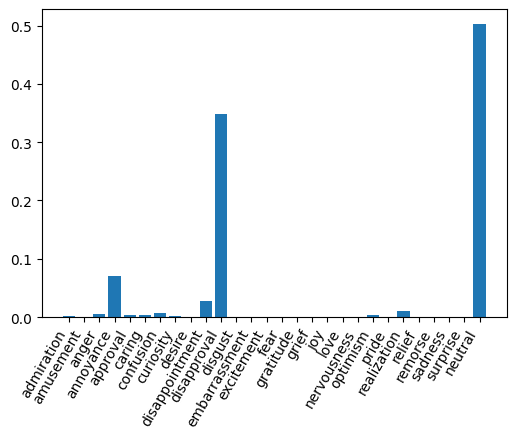

In [ ]:
display_sentiment("No mountain, nor sea, no thing of this world could keep us apart, because this is not my world... you are.")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


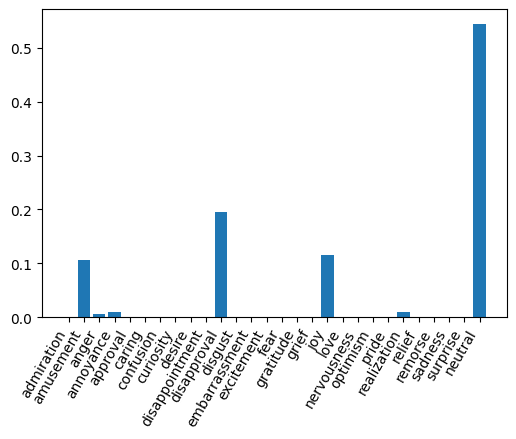

In [ ]:
display_sentiment("this is not fun")

## example sentences (from poems)
- No mountain, nor sea, no thing of this world could keep us apart, because this is not my world... you are.
- hold fast to dreams for if dreams die life is a broken-winged bird that cannot fly.

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


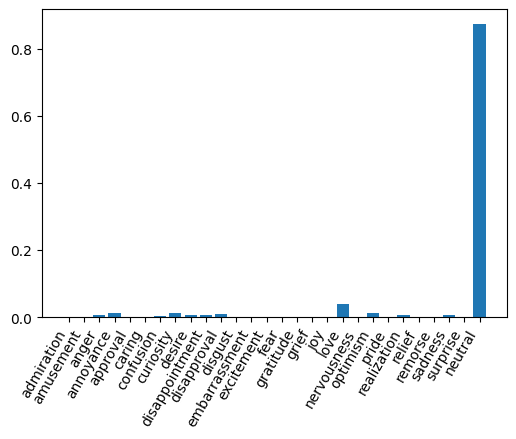

In [ ]:
display_sentiment("hold fast to dreams for if dreams die life is a broken-winged bird that cannot fly.")

<ipython-input-46-fc8f1d42e349>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(torch.stack(embedded))
<ipython-input-49-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


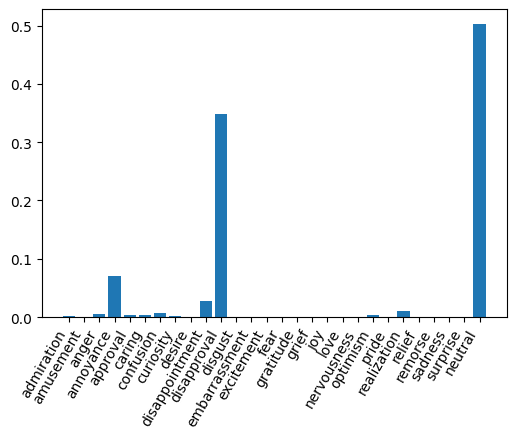

In [ ]:
display_sentiment("No mountain, nor sea, no thing of this world could keep us apart, because this is not my world... you are.")